# Convolution Neural Network for Image Classification

NOTE: In order to run it quickly we will need to enable GPU acceleration.

In the top menu go to Edit -> Notebook Settings -> Hardware Acceleration and
click on GPU

If you do not do this, training of the neural networks will take **much**
longer.

In [1]:
import os
import warnings

from keras.datasets import cifar10
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

Visualization functions:

In [2]:
def plot_loss_accuracy(
    history: tf.keras.callbacks.History,
    save_path: str | None = None,
) -> None:
    """Plot the training and validation curves.

    Args:
        history (A tf.keras.callbacks.History): object returned by model.fit.
        save_path (str): where the image will be saved.
    """
    # Create a DataFrame from the training history.
    history_df = pd.DataFrame(history.history, index=history.epoch)

    # Create the plot.
    plt.figure(figsize=(8, 6))
    history_df.plot(ylim=(0, max(1, history_df.to_numpy().max())))

    # Annotate the plot with the final loss and accuracy.
    # loss = history.history["loss"][-1]
    # acc = history.history["accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    val_acc = history.history["val_accuracy"][-1]
    plt.title(f"Validation: Loss = {val_loss:.3f}, Acc = {val_acc:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    # Save the plot if a path is provided.
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


def visualize_feature_maps(
    model: Model,
    sample_image: np.ndarray,
    *,
    images_per_row: int = 16,
    layer_indices: list[int] | None = None,
    output_dir: str | None = None,
) -> None:
    """Visualize feature maps (activations) from selected layers of the model.

    Args:
        model (Model): A trained Keras model.
        sample_image (np.ndarray): A single image to visualize the activations.
        images_per_row (int): Number of images to display per row.
        layer_indices (list[int]): Indices of the layers to visualize.
        output_dir (str | None): Directory to save the feature map images.
    """
    if layer_indices is None:
        layer_indices = list(range(8))

    # Extract outputs for the specified layers.
    layer_outputs = [model.layers[i].output for i in layer_indices]
    activation_model = Model(inputs=model.inputs, outputs=layer_outputs)

    # Predict activations for the provided sample image.
    activations = activation_model.predict(np.expand_dims(sample_image,
                                                          axis=0))

    # Loop through each layer's activations and create a grid image.
    for idx, activation in zip(layer_indices, activations):
        layer_name = model.layers[idx].name
        n_features = activation.shape[-1]
        size = activation.shape[1]  # Assuming square activation maps.
        n_cols = n_features // images_per_row  # Number of rows in the grid.
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # Fill the grid with activation channel images.
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_index = col * images_per_row + row
                if channel_index < n_features:
                    channel_image = activation[0, :, :, channel_index]
                    # Post-process the feature map for better visualization.
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std() + 1e-5
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0,
                                            255).astype("uint8")
                    display_grid[
                        col * size:(col + 1) * size,
                        row * size:(row + 1) * size,
                    ] = channel_image

        # Create the figure and save the grid.
        scale = 1.0 / size
        plt.figure(figsize=(
            scale * display_grid.shape[1],
            scale * display_grid.shape[0],
        ))
        plt.title(layer_name)
        plt.grid(visible=True)
        plt.imshow(display_grid, aspect="auto", cmap="viridis")

        # Save the activation grid images if an output directory is provided.
        if output_dir is None:
            plt.show()
        else:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f"{layer_name}.png")
            plt.savefig(output_file)
            plt.close()

As we seen, fully connected neural networks are powerful tools for vectorized
data.
By converting images to vectors, we can use fully connected networks to
classify images, as we did with MNIST.
However, when we have larger images and colour images, the number of parameters
quickly gets out of hand.

Lets download the Cifar10 dataset and have a look at it.
[More information on Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [3]:
def load_cifar10(
    *,
    flatten: bool = False,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, tuple[int, int,
                                                                 int], int]:
    """Load CIFAR-10 dataset, normalize pixel values, and flatten images.

    Args:
        flatten: If True, reshape images to vectors.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, tuple[int, int,
            int], int]: Training and testing data, image shape, and size.
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalize the images to [0, 1]
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    # Get image dimensions
    img_shape = x_train.shape[1:]  # (32, 32, 3)
    img_size = np.prod(img_shape)

    if flatten:
        x_train = x_train.reshape(x_train.shape[0], img_size)
        x_test = x_test.reshape(x_test.shape[0], img_size)

    # Convert labels to one-hot vectors
    num_classes = 10
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return x_train, y_train, x_test, y_test, img_shape, img_size


num_classes = 10
# Load the CIFAR-10 dataset and flatten the images
x_train_fc, _, x_test_fc, _, img_shape, img_size = load_cifar10(flatten=True)
# For CNN models, keep the images in their original shape.
x_train, y_train, x_test, y_test, img_shape, _ = load_cifar10(flatten=False)

Lets have a look at the dimensions of the cifar images and check out the first image in the dataset.

Training data shape:  (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)
Training response shape:,  (50000, 10)
Testing response shape:  (10000, 10)


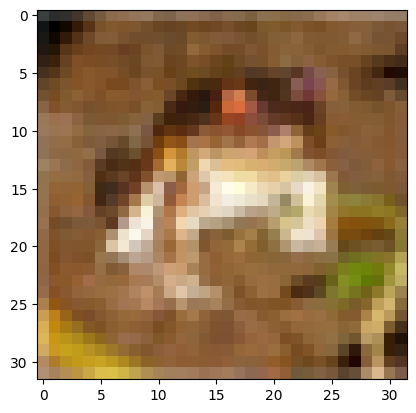

In [4]:
# (50000, 32, 32) -- 60000 images, each 32x32 pixels
print("Training data shape: ", x_train.shape)
# (10000, 28, 28) -- 10000 images, each 32x32
print("Test data shape", x_test.shape)
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

assert img_shape == (x_train.shape[1], x_train.shape[2], x_train.shape[3])
plt.imshow(x_train[0])

From this we can see that we have images that are 32 * 32 * 3.
This means we have a 32 * 32 image with 3 different colour channels (RGB).
If we convert this to a vector we will have a vector of length
32 * 32 * 3 = 3072, which is significanlty larger than what we had to deal with
for MNIST.

Let's reshape (flatten) these arrays.
The images will be converted to vectors.
However, unlike last time, we aren't going to overwrite the x_train and x_test
objects, we will keep them around for later.

In [5]:
assert img_size == img_shape[0] * img_shape[1] * img_shape[2]
print(f"Training flat data shape: {x_train_fc.shape}")

Training flat data shape: (50000, 3072)


Before moving onto building the network we need to convert the labels into
one-hot-encoded target labels.
Like last time we are using the to_categorical function to do this.

In [6]:
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)


Lets build a simple fully connected model similar to last week, but with two hidden layers this time.

In [7]:
def build_fc_model(input_shape: tuple, num_classes: int) -> Sequential:
    """Build a basic fully connected neural network."""
    model = Sequential()
    model.add(Dense(units=1024, activation="sigmoid", input_shape=input_shape))
    model.add(Dense(units=256, activation="sigmoid"))
    model.add(Dense(units=num_classes, activation="softmax"))
    return model


fc_model = build_fc_model((img_size, ), num_classes)
fc_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411,722 (13.01 MB)

 Trainable params: 3,411,722 (13.01 MB)

 Non-trainable params: 0 (0.00 B)

With nearly 3.5 million parameters to learn, our model is quite large.
Let's compile the model with an ADAM optimizer.

In [8]:
fc_model.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

Learning from the last lab, we will train for 50 epochs the first time around.
That seems to be learning well, lets have a look at the loss /accuracy curves.

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.2281 - loss: 2.1316 - val_accuracy: 0.3390 - val_loss: 1.8344
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3578 - loss: 1.8088 - val_accuracy: 0.3894 - val_loss: 1.7229
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3909 - loss: 1.7029 - val_accuracy: 0.3964 - val_loss: 1.6786
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4181 - loss: 1.6279 - val_accuracy: 0.4116 - val_loss: 1.6367
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4451 - loss: 1.5648 - val_accuracy: 0.4414 - val_loss: 1.5924
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4541 - loss: 1.5331 - val_accuracy: 0.4556 - val_loss: 1.5496
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4705 - loss: 1.4888 - val_accuracy: 0.4620 - val_loss: 1.5156
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4903 - loss: 1.4402 - val_accuracy: 0.4612 - val_los

I0000 00:00:1739756249.387900   80843 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_46', 252 bytes spill stores, 252 bytes spill loads



<Figure size 800x600 with 0 Axes>

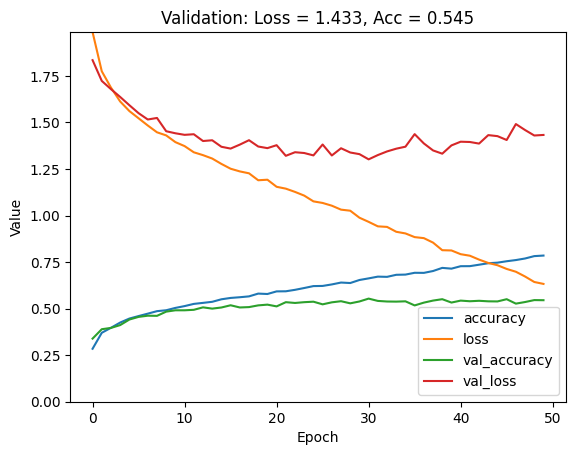

Fully Connected Model - Val Loss: 1.462, Val Acc: 0.530



In [9]:
history_fc = fc_model.fit(
    x_train_fc,
    y_train,
    batch_size=512,
    epochs=50,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)
loss_fc, acc_fc = fc_model.evaluate(x_test_fc, y_test, verbose=0)
plot_loss_accuracy(history_fc)
print(
    f"Fully Connected Model - Val Loss: {loss_fc:.3f}, Val Acc: {acc_fc:.3f}\n"
)

In the early stage of training all is going well, but the model is not
generalizing well towards the end!
This can be seen by the widening gap between the validation and training loss
and accuracy lines.
This is a sign that the network is *overfitting*.

This overfitting may be related to the fact that we have over 3.5 million
parameters in our model.
Imagine if we had a larger input image, the number of parameters would explode!
If we had a 300 * 300 RGB image then we would have over 300 million parameters
for our little 2 layer network.

Finally, our vectorized data and the fully connected model doesn't take into
account any of the spatial relationships in the image, as its just jumbles all
the pixels around into a single vector.

For these reasons we would like to move on to a *Convolutional Neural Network*.

Let's write a function to put together a convolutional neural network.
We will be using a new layer called **Conv2D**.
The Conv2D layer takes in the following arguments:

1. Number of filters, this is similar to setting the number of neurons in a
   Dense layer. Must be an integer.
2. Filter size, , the dimension of each filter being used. Tuple of integers
3. Activation, same sort of functions as we used for Dense layers.
4. Padding, this determines if the model adds extra rows /columns to the input.
   This gives control over the shape of the output.

More information on convolutional layers can be found
[here](https://keras.io/layers/convolutional/).

One thing to note about convolutional neural networks is that they still
normally have the Dense layers in the end like a usual fully-connected network.

Below is a function that puts together a simple convolutional network:

In [10]:
def build_convnet(image_size: tuple, num_classes: int) -> Sequential:
    """Build a basic convolutional neural network."""
    model = Sequential()
    model.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            padding="same",
            input_shape=image_size,
        ))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    return model


print("Building convolutional neural network...")
conv_model = build_convnet(img_shape, num_classes)
conv_model.summary()

Building convolutional neural network...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Training convolutional model...
Epoch 1/50


I0000 00:00:1739756274.884978   81006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_471', 8 bytes spill stores, 8 bytes spill loads



168/176 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2363 - loss: 2.1099  

I0000 00:00:1739756279.036381   81092 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_471', 64 bytes spill stores, 64 bytes spill loads



176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2402 - loss: 2.1006

I0000 00:00:1739756281.546886   81236 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 64 bytes spill stores, 64 bytes spill loads



176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2406 - loss: 2.0995 - val_accuracy: 0.4096 - val_loss: 1.6249
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4335 - loss: 1.5813 - val_accuracy: 0.4624 - val_loss: 1.4894
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4761 - loss: 1.4571 - val_accuracy: 0.5100 - val_loss: 1.3794
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5150 - loss: 1.3582 - val_accuracy: 0.5320 - val_loss: 1.3368
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5411 - loss: 1.3118 - val_accuracy: 0.5600 - val_loss: 1.2587
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5553 - loss: 1.2585 - val_accuracy: 0.5710 - val_loss: 1.2267
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5751 - loss: 1.2102 - val_accuracy: 0.5804 - val_loss: 1.1939
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5946 - loss: 1.1685 - val_accuracy: 0.5950 - val

I0000 00:00:1739756345.281296   83691 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 8 bytes spill stores, 8 bytes spill loads



<Figure size 800x600 with 0 Axes>

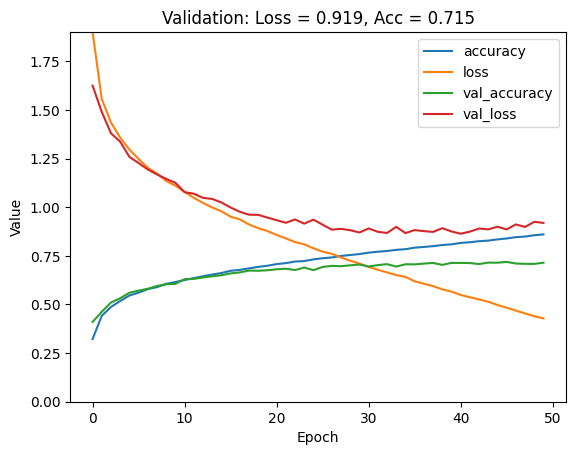

Convolutional Model - Val Loss: 0.948, Val Acc: 0.703



In [11]:
conv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print("Training convolutional model...")
history_conv = conv_model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=50,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)
loss_conv, acc_conv = conv_model.evaluate(x_test, y_test, verbose=0)
plot_loss_accuracy(history_conv)
print("Convolutional Model - "
      f"Val Loss: {loss_conv:.3f}, Val Acc: {acc_conv:.3f}\n")

We can see here that the model is doing better than the fully connected one but
it started to overfit again towards the end.
Let's **add some Dropout layers** to try and combat this.

In [16]:
def build_dropout_convnet(image_size: tuple, num_classes: int) -> Sequential:
    """Build a Conv NN with dropout layers to reduce overfitting."""
    model = Sequential()
    model.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            padding="same",
            input_shape=image_size,
        ))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation="softmax"))
    return model


print("Building dropout convolutional neural network...")
dropout_model = build_dropout_convnet(img_shape, num_classes)
dropout_model.summary()

Building dropout convolutional neural network...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Lets compile and train the model for the same number of epochs as before.
Hopefully, thats a bit better, lets have a look at the loss / accuracy curves and check the test accuracy.

Training dropout convolutional model...
Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.1419 - loss: 2.2661 - val_accuracy: 0.3020 - val_loss: 2.0109
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3080 - loss: 1.9305 - val_accuracy: 0.3708 - val_loss: 1.7450
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3737 - loss: 1.7403 - val_accuracy: 0.4104 - val_loss: 1.6251
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4076 - loss: 1.6389 - val_accuracy: 0.4368 - val_loss: 1.5465
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4359 - loss: 1.5649 - val_accuracy: 0.4626 - val_loss: 1.4836
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4457 - loss: 1.5136 - val_accuracy: 0.4766 - val_loss: 1.4397
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4667 - loss: 1.4740 - val_accuracy: 0.4940 - val_loss: 1.3953
Epoch 8/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4891 

<Figure size 800x600 with 0 Axes>

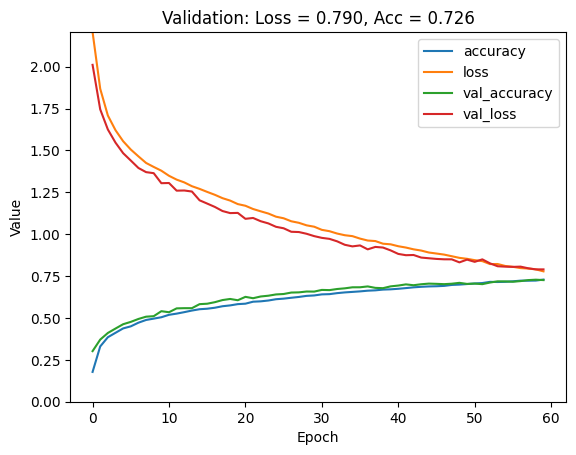

Dropout Convolutional Model - Val Loss: 0.817, Val Acc: 0.716



In [17]:
dropout_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print("Training dropout convolutional model...")
history_dropout = dropout_model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=60,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)
loss_dropout, acc_dropout = dropout_model.evaluate(x_test, y_test, verbose=0)
plot_loss_accuracy(history_dropout)
print("Dropout Convolutional Model - "
      f"Val Loss: {loss_dropout:.3f}, Val Acc: {acc_dropout:.3f}\n")

Great! The convolutional model works and is not saturated after 60 epochs.
This indicates how much the dropout layers have improved the generalization
performance of the model.

However, to help us get an idea of whats actually going on lets look at how
the layers respond to a particular image.
In other words, let's look at **feature maps**!

First, let's look at an image that we are going to use.
Feel free to change this index to whatever number you like, so you can see how
it works with different images.

Lets see how one of the first filters is responding to this image.
If we plot single layer of this feature map we can see that is will be picking
up specific features of the input image.

Lets plot all the activation maps, don't worry about how the code works in this
section, it is just for demonstration.

Visualizing feature maps for image index: 0


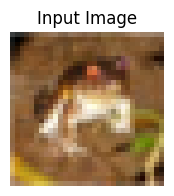

In [18]:
demo_image_index = 0  # Change this index to visualize a different image
print("Visualizing feature maps for image index:", demo_image_index)
plt.figure(figsize=(2, 2))
plt.imshow(x_train[demo_image_index])
plt.title("Input Image")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


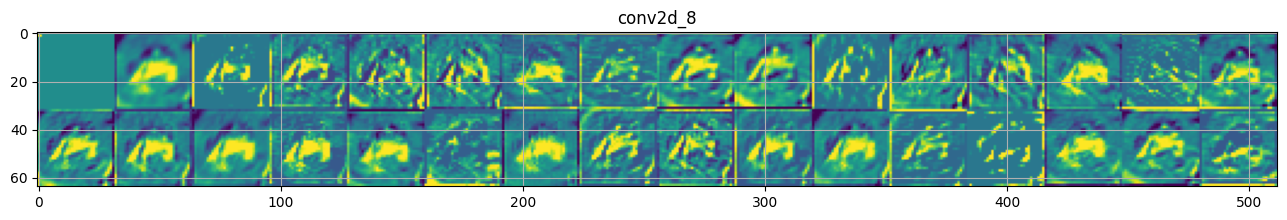

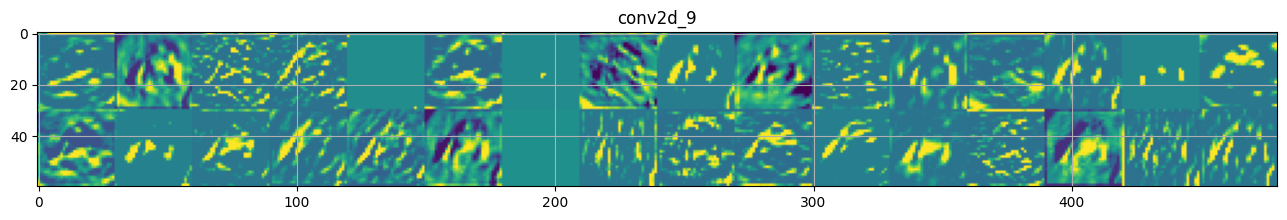

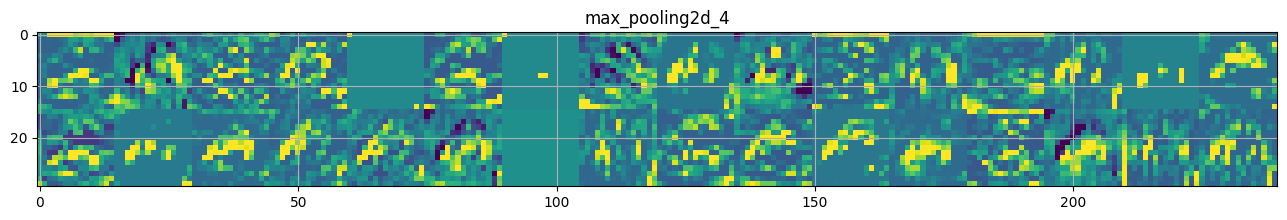

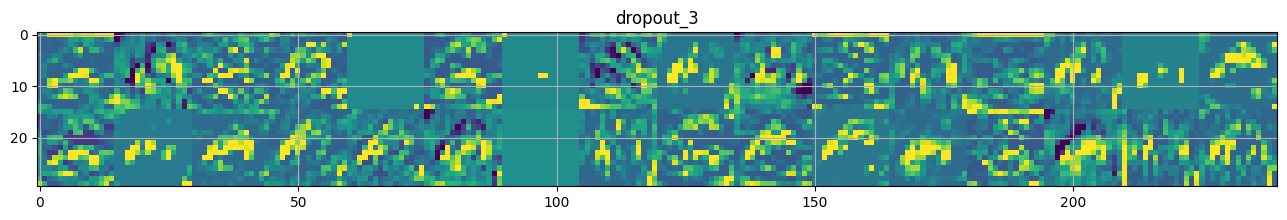

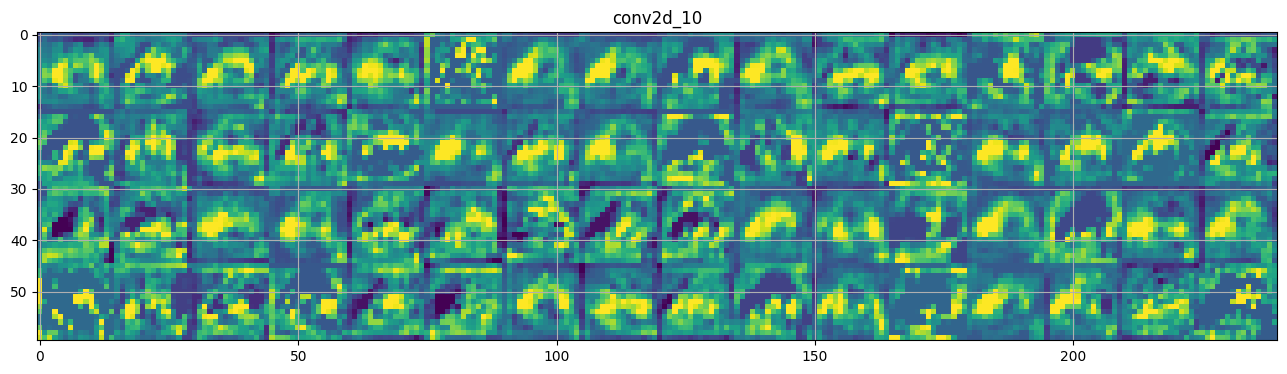

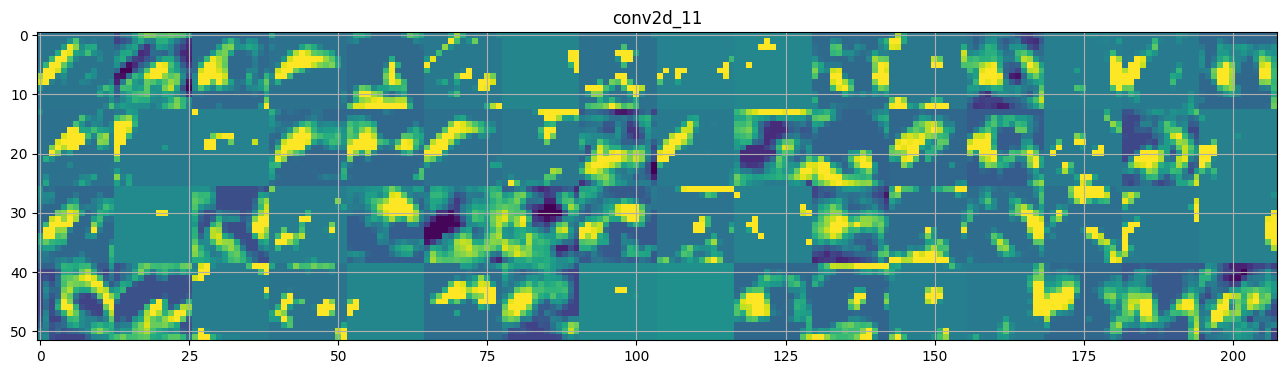

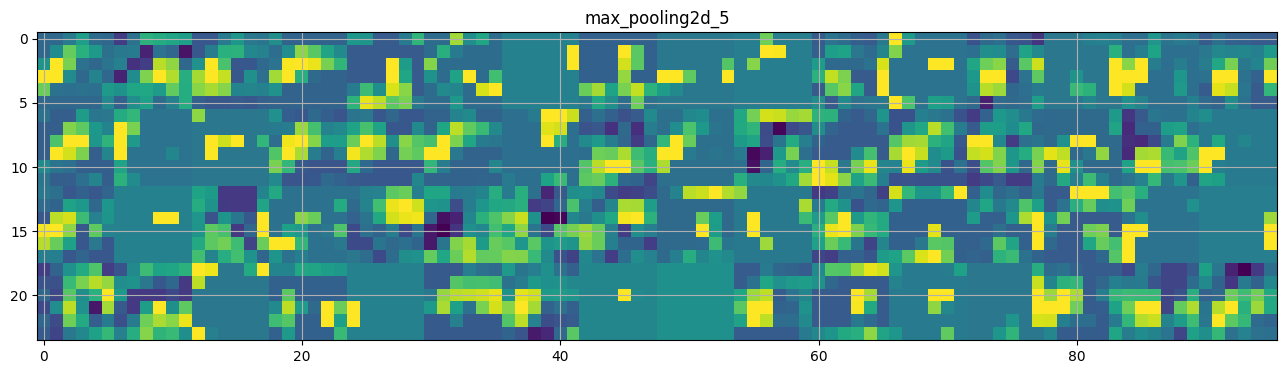

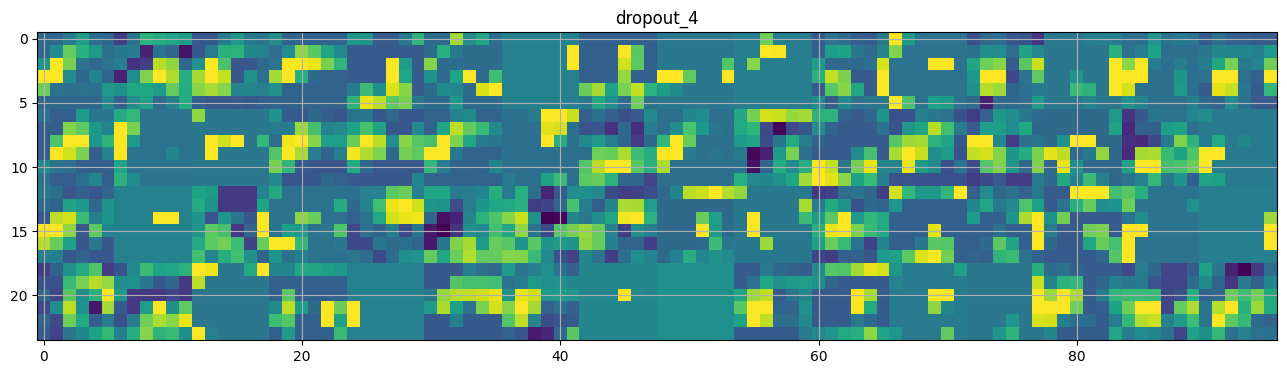

In [19]:
# Visualize feature maps from the first 8 layers of the dropout model
visualize_feature_maps(dropout_model,
                       x_train[demo_image_index])